## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

2.15.0


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive")
!ls

In [9]:
data = pd.read_csv('lenta_40k.csv')

In [11]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [12]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [14]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [15]:
id2word = {i:word for word, i in word2id.items()}

In [16]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [17]:
MEAN_LEN = np.median([len(x) for x in X])

In [18]:
MAX_LEN = int(MEAN_LEN + 30)

In [19]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [20]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [21]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [90]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model.weights.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

Layer counter: 16

In [91]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

convs = []
for ks in [64,48,32]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    drop1 = keras.layers.Dropout(0.1)(conv1)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=2,
                                  kernel_regularizer='l2', activation='relu')(drop1)
    convs.append(conv2)
concat1 = keras.layers.concatenate(convs, axis=1)

pool1 = keras.layers.AveragePooling1D(pool_size=2)(concat1)
conv3 = keras.layers.Conv1D(kernel_size=32, filters=64, strides=1)(pool1)
conv4 = keras.layers.Conv1D(kernel_size=24, filters=64, strides=2)(conv3)
conv5 = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1)(conv4)
conv6 = keras.layers.Conv1D(kernel_size=8, filters=32, strides=3, activation='relu')(conv5)
concat2 = keras.layers.Flatten()(conv6)

dense1 = keras.layers.Dense(64, activation='relu')(concat2)
drop2 = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(64, activation='relu')(drop2)

concat3 = keras.layers.Flatten()(dense2)
dense2 = keras.layers.Dense(50, activation='relu')(concat3)
drop2 = keras.layers.Dropout(0.3)(dense2)
dense3 = keras.layers.Dense(50, activation='relu')(drop2)

flatten = keras.layers.Flatten()(dense3)
dense4 = keras.layers.Dense(80, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense4)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [92]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 embedding_36 (Embedding)    (None, 200, 100)             2409200   ['input_37[0][0]']            
                                                                                                  
 conv1d_289 (Conv1D)         (None, 200, 32)              204832    ['embedding_36[0][0]']        
                                                                                                  
 conv1d_291 (Conv1D)         (None, 200, 32)              153632    ['embedding_36[0][0]']        
                                                                                            

In [93]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=20,
          callbacks=[checkpoint])

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 1.0218 - rec@prec: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.40589, saving model to model.weights.h5
22/22 [==============================] - 12s 287ms/step - loss: 1.0218 - rec@prec: 0.0000e+00 - val_loss: 0.4059 - val_rec@prec: 0.0000e+00
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 0.2851 - rec@prec: 0.0000e+00
Epoch 2: val_loss improved from 0.40589 to 0.19826, saving model to model.weights.h5
22/22 [==============================] - 6s 289ms/step - loss: 0.2851 - rec@prec: 0.0000e+00 - val_loss: 0.1983 - val_rec@prec: 0.0000e+00
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.1900 - rec@prec: 2.3732e-05
Epoch 3: val_loss improved from 0.19826 to 0.17996, saving model to model.weights.h5
22/22 [==============================] - 6s 270ms/step - loss: 0.1900 - rec@prec: 2.3732e-05 - val_loss: 0.1800 - val_rec@prec: 0.0000e+00
Epoch 4/20
22/22 [===================

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


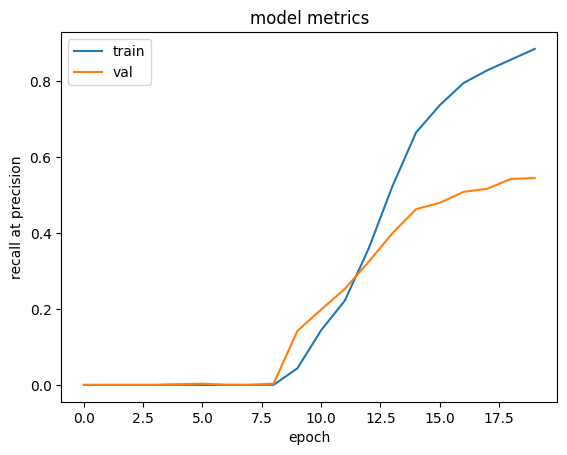

In [94]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


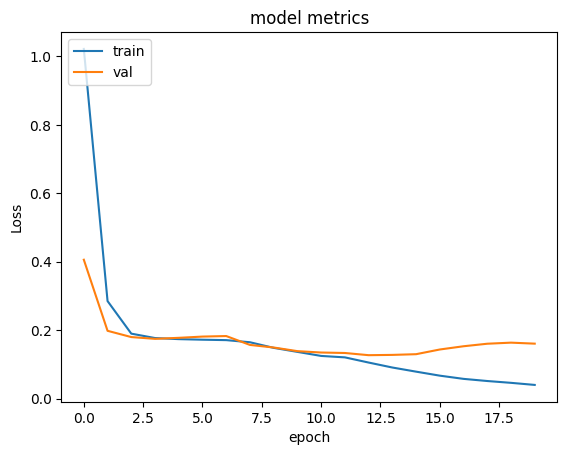

In [95]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model metrics')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Чекпоинты вообще никак не находят f1 availible, по-разному пробовал и документацию тоже смотрел. По лоссу сохранять получается. В примере лосс прекратил уменьшаться на 14й эпохе, но recall at precision все еще рос